Project berry-wise features to 2D uMAP space

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import r_utils
from models import PredictionModel
from dataset import (
    CranberryPatchDataset, CranberryBerryWiseDataset,
    DefaultSplitDescriptor, CoordSplitDescriptor, GenotypeSplitDescriptor,
)

from ipynb.fs.full.data_prep import get_berry_wise_df
from typing import Optional, Callable
import umap
import torch
import torch.functional as F
from transformers import AutoImageProcessor
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

Load model and image processor:

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PredictionModel(
    backbone_name='facebook/dinov2-with-registers-base',
    # backbone_name='google/vit-base-patch16-224',
    prediction_heads = [],
    lora_options=None,
    do_normalization=True
).to(device)

# model.load('./checkpoints/fungicide_time/facebook_dinov2-with-registers-base_time_fungicide_10_epochs_21h34m.pth')
# model.load('./checkpoints/fungicide_heads/facebook_dinov2-with-registers-base_fungicide_10_epochs_20h34m.pth')
# model.load('./coord_split_checkpoints/facebook_dinov2-with-registers-base_time_fungicide_8_epochs_17h5m.pth')
# model.load('./checkpoints/geno_drop_test/google_vit-base-patch16-224_time_genotype_8_epochs_10h41m.pth')
# model.load('./checkpoints_bw/facebook_dinov2-with-registers-base_geno_time_4_epochs_bw_4h53m.pth')

checkpoint_name = './checkpoints_pw/h2.pth'
model.load(checkpoint_name)

processor = AutoImageProcessor.from_pretrained(
    model.backbone_name,
    do_rescale=False,
    do_resize=False,
    use_fast=False
)

Loading from ./checkpoints_pw/h2.pth


Prepare the dataset identically to how it was done when training the loaded checkpoint:

In [18]:
dataset_locations = r_utils.load_toml('./dataset_locations.toml')
berry_wise_df = get_berry_wise_df()
dataset = CranberryBerryWiseDataset(berry_wise_df, dataset_locations)

# use the dataset split descriptor that was stored in the model checkpoint
data_splits = model.dataset_split_descriptor.split(dataset)
val_dataset = data_splits['test_dataset']
val_idxs = data_splits['test_idxs']

gen1 = torch.Generator().manual_seed(1)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, generator=gen1)

print(model.dataset_split_descriptor)

Splitting dataset by track
Attempting to split the dataset with a 0.7/0.3 split. Actual split: 0.68/0.32.
TrackSplitDescriptor(approx_train_size=0.7, random_state=1)


Get the embedding:

In [19]:
@torch.no_grad()
def run_inference(model, processor, dataloader):
    model.eval()
    device = next(model.parameters()).device
    all_outputs = []

    print(f"Running inference on {device}")
    for patch, _ in tqdm(dataloader):
        if processor is not None:
            inputs = processor(patch, return_tensors='pt').to(device)
        else:
            inputs = {'pixel_values': patch.to(device)}
            
        outputs = model(inputs)['latent']
        all_outputs.append(outputs.cpu())

    return torch.cat(all_outputs, dim=0)

features = run_inference(model, processor, val_dataloader)

Running inference on cuda:0


100%|██████████| 28/28 [00:03<00:00,  7.72it/s]


In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=features.shape[0]-1, random_state=1)
embedding = reducer.fit_transform(features)

Plot the data

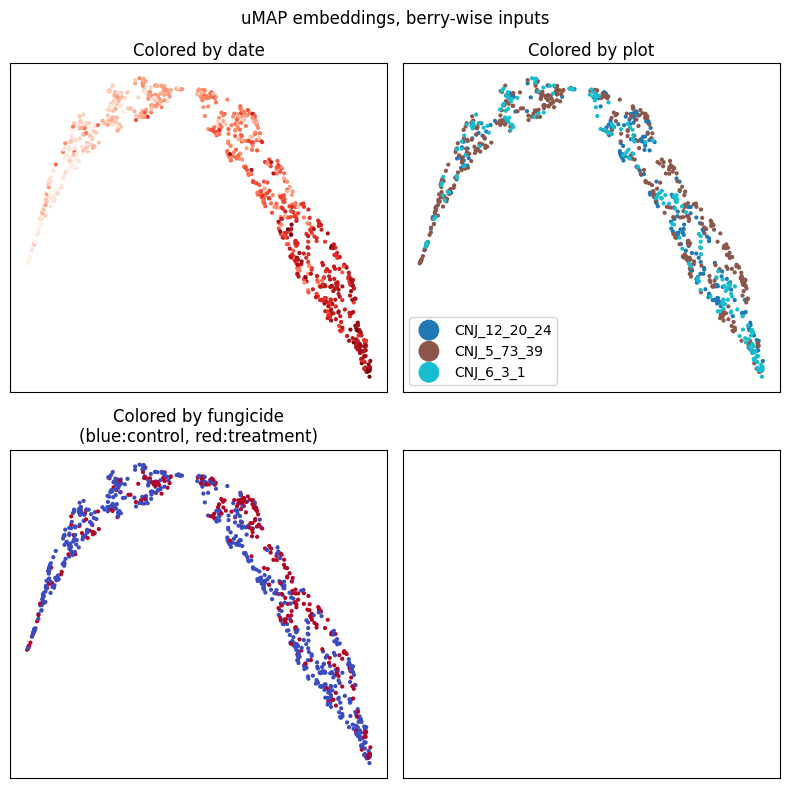

In [30]:
relevant_rows = berry_wise_df.iloc[val_idxs]

date_codes = relevant_rows['date'].astype('category').cat.codes
plot_codes = relevant_rows['plot'].astype('category').cat.codes
plot_labels = list(relevant_rows['plot'])
fungicide_codes = relevant_rows['fungicide'].astype('category').cat.codes

date_c, _ = r_utils.values_to_colors(list(date_codes), cmap_name='Reds')
plot_c, _ = r_utils.values_to_colors(list(plot_codes), cmap_name='tab10')
fungicide_c, fclist = r_utils.values_to_colors(list(fungicide_codes), cmap_name='coolwarm')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axs = axs.flatten()
axs[0].scatter(*embedding.T, s=4, c=date_c)
axs[0].set_title("Colored by date")


axs[1].set_title("Colored by plot")
for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    axs[1].scatter(
        embedding[i, 0], embedding[i, 1], label=label, s=4, c=np.array(plot_c)[i]
    )
l1 = axs[1].legend(markerscale=7)

axs[2].scatter(*embedding.T, s=4, c=fungicide_c)
axs[2].set_title("Colored by fungicide\n(blue:control, red:treatment)")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("uMAP embeddings, berry-wise inputs")
plt.tight_layout()
plt.show()

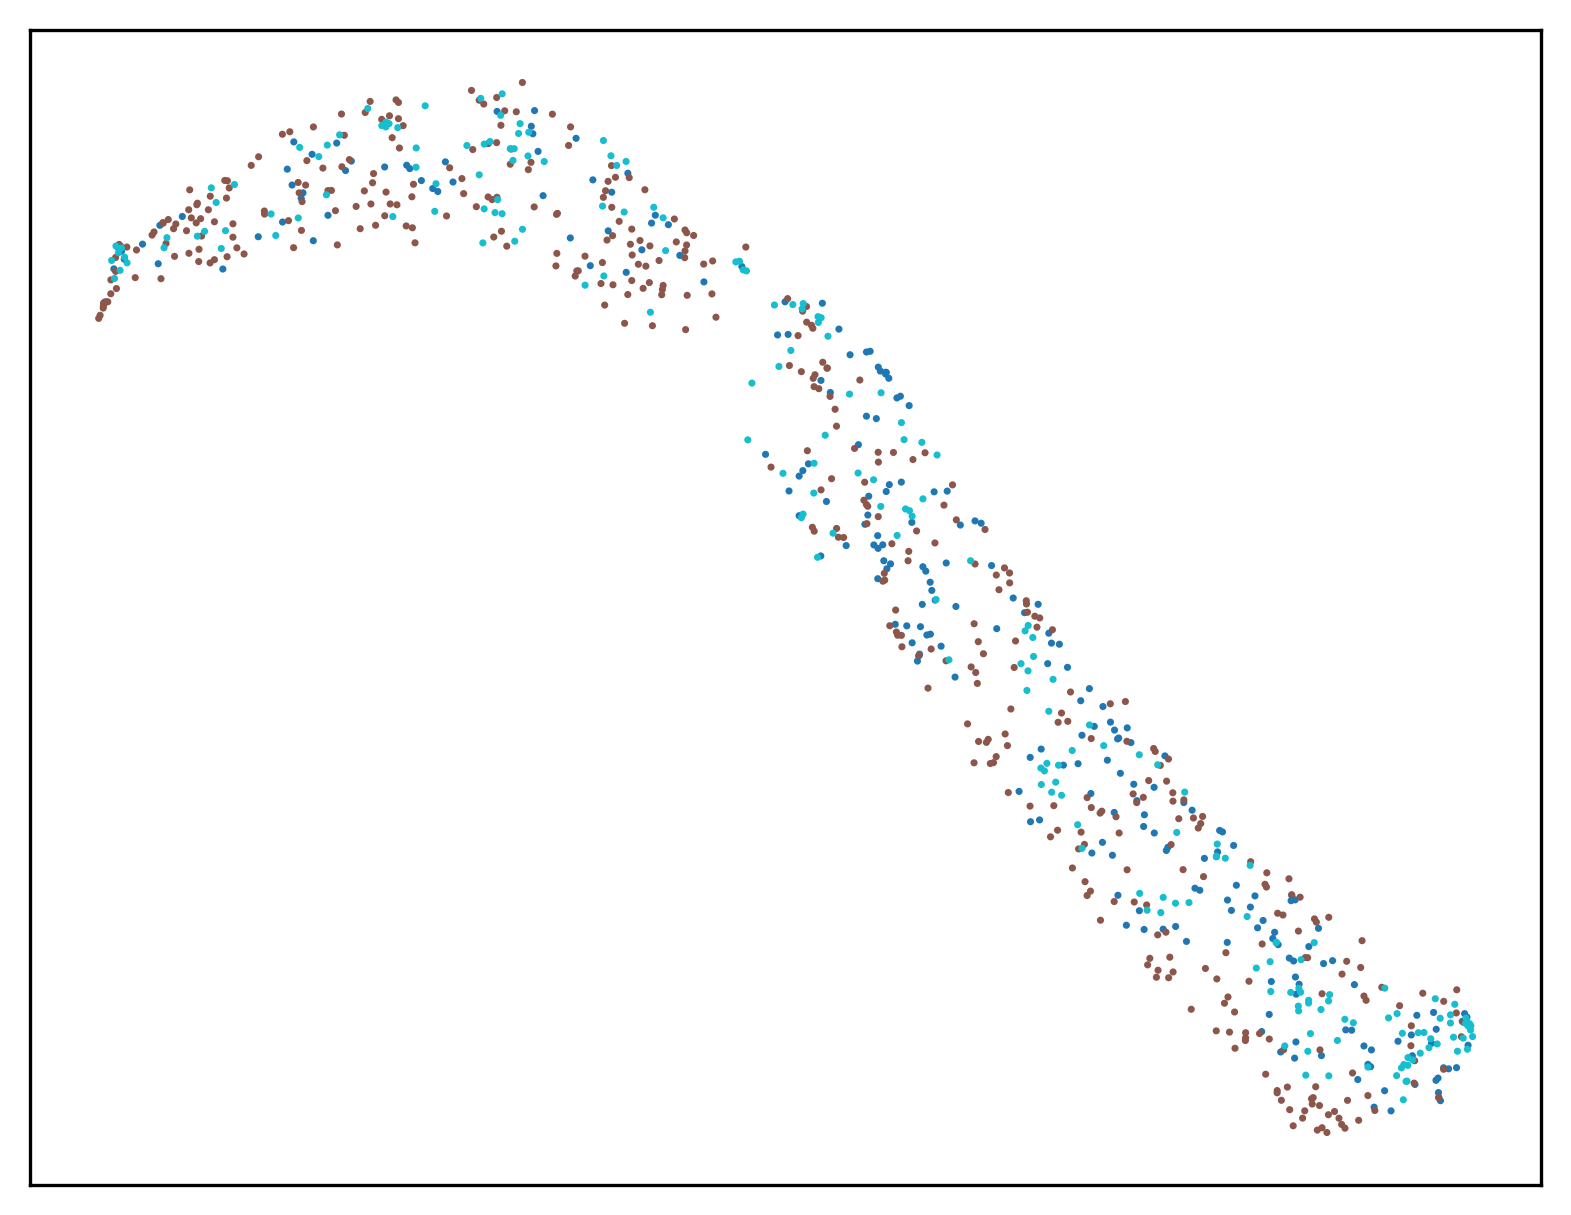

In [23]:
fig_scale=0.5
fig_size = (13, 10)
plt.figure(figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), dpi=300)

for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    plt.scatter(
        embedding[i, 0], embedding[i, 1], label=label, s=0.5, c=np.array(plot_c)[i]
    )

plt.xticks([])
plt.yticks([])
plt.show()

Visualizations with images

**Note:** you may have to run this cell or the following cell twice to get the correct plot to show up

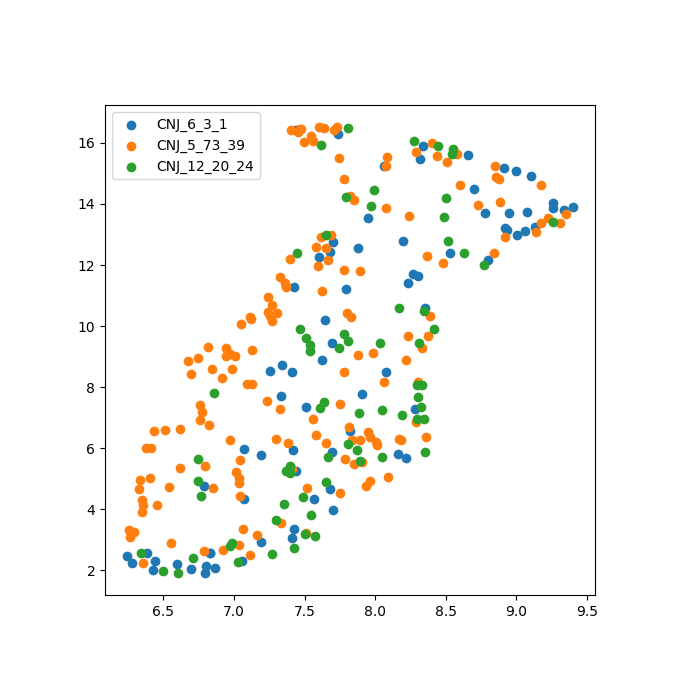

In [16]:
%matplotlib widget
import plotting_vis
from importlib import reload
reload(plotting_vis)

# take only a smaller subset of points to plot
k = 300
np.random.seed(3)
indices = np.random.choice(embedding.shape[0], size=k, replace=False, )

features_subset = np.array(embedding[indices])
rich_labels = relevant_rows[['plot', 'date', 'fungicide']].iloc[indices].to_dict(orient='list')

p_dev = torch.tensor(processor.image_std).view(3,1,1)
p_mean = torch.tensor(processor.image_mean).view(3,1,1)
images = [val_dataset[i][0] for i in indices]

plotting_vis.plot_with_annotations(features_subset, rich_labels['plot'], images, figsize=(7,7), cmap='tab10')
%matplotlib inline